In [396]:
from typing import Iterable
import numpy as np

import shapely.ops
import shapely.geometry as geom
import shapely.affinity as affine
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

import geopandas as gpd

In [784]:
def equal_tuples(t1:Iterable[float],
                 t2:Iterable[float]) -> bool:
  return np.allclose(t1, t2, atol = 1e-5)

def round_tuple(t):
  return tuple([np.round(x, 1) for x in t])

# Implements Knuth-Morris-Pratt see:
# https://en.wikipedia.org/wiki/Knuth–Morris–Pratt_algorithm
# but for sequences of tuples of floats
def find_matches(seq:Iterable[tuple[float]], 
                 pat:Iterable[tuple[float]],
                 equals = equal_tuples) -> list[int]:
  # print(
  #   f"""
  #   Searching for: 
  #   {[round_tuple(t) for t in pat]} in
  #   {[round_tuple(t) for t in seq]}
  #   """)
  j, k, = 0, 0
  finds = []
  table = get_table(pat)
  while j < len(seq):
    if equals(pat[k], seq[j]):
      j = j + 1
      k = k + 1
      if k == len(pat):
        finds.append(j - k)
        k = table[k]
    else:
      k = table[k]
      if k < 0:
        j = j + 1
        k = k + 1
  return finds

def get_table(pattern:Iterable,
              equals = equal_tuples) -> Iterable:
  pos = 1
  cnd = 0
  T = {0: -1}
  
  while pos < len(pattern):
    if np.allclose(pattern[pos], pattern[cnd]):
      T[pos] = T[cnd]
    else:
      T[pos] = cnd
      while cnd >= 0 and not equals(pattern[pos], pattern[cnd]):
        cnd = T[cnd]
    pos = pos + 1
    cnd = cnd + 1
  
  T[pos] = cnd
  return tuple(T.values())

In [1099]:
def get_lengths_and_angles(p:geom.Polygon) -> list[tuple[float]]:
  lengths = tiling_utils.get_edge_lengths(p)
  angles = tiling_utils.get_interior_angles(p)
  return list(zip(lengths + lengths[:1], angles + angles[:1]))

def get_edge_bearings(p:geom.Polygon) -> tuple[tuple[float]]:
  c = p.centroid
  # don't set_precision on this - it changes the point order!
  pdash = affine.translate(p, -c.x, -c.y)
  edges = tiling_utils.get_edges(pdash)
  return tuple([np.degrees(np.arctan2(
    # e.coords[1][1], e.coords[1][0])) 
    e.coords[1][1] - e.coords[0][1], e.coords[1][0] - e.coords[0][0])) 
    for e in edges])

# Based on
# Eades, P. 1988. Symmetry Finding Algorithms. In Machine Intelligence and 
# Pattern Recognition, ed. G. T. Toussaint, 6:41–51. Computational Morphology. 
# North-Holland. doi: 10.1016/B978-0-444-70467-2.50009-6.
# and also
# Wolter, J. D., T. C. Woo, and R. A. Volz. 1985. Optimal algorithms for 
# symmetry detection in two and three dimensions. The Visual Computer 1(1): 
# 37–48. doi: 10.1007/BF01901268.
def find_symmetries(p:geom.Polygon) -> tuple[tuple[float], tuple[float]]:
  encoded_polygon = get_lengths_and_angles(p)
  plain_code = encoded_polygon[:-1]
  n = len(plain_code)
  # rotations
  S = plain_code + plain_code[:-1]
  rotation_matches = find_matches(S, plain_code)
  print(f"{rotation_matches=}")
  # reflections
  reflected_code = list(reversed(encoded_polygon[1:]))
  S = list(reversed(S))
  reflection_matches = find_matches(S, reflected_code)
  print(f"{reflection_matches=}")
  reflections = []
  edge_bearings = list(reversed(get_edge_bearings(p)))
  for m in reflection_matches:
    i = (n + m) // 2
    print(f"{n=},{m=},{i=},{'edge' if (n+m)%2==0 else 'corner'}")
    if (n + m) % 2 == 0:
      reflections.append((edge_bearings[i] - 90) % 360)
    else:
      reflections.append(edge_bearings[i] + plain_code[i][1] / 2)
  
  return {"rotations": tuple([x / n * 360 for x in rotation_matches]),
          "reflections": tuple(reflections)}


In [1102]:
poly = affine.scale(tiling_utils.get_regular_polygon(1000, n = 3), 0.8)
# poly = tiling_utils.get_regular_polygon(1000, n = 4)
# poly = tiling_utils.get_regular_polygon(1000, n = 5)
# poly = TileUnit(tiling_type = "hex-dissection", n = 3).elements.geometry[0]
# poly = TileUnit(tiling_type = "hex-dissection", n = 12).elements.geometry[0]
# poly = TileUnit(tiling_type = "hex-dissection", n = 6).elements.geometry[0]
# poly = TileUnit(tiling_type = "cairo", n = 3).elements.geometry[0]
poly = affine.translate(poly, -poly.centroid.x, -poly.centroid.y)

symmetries = find_symmetries(poly)
symmetries

rotation_matches=[0]
reflection_matches=[1]
n=3,m=1,i=2,edge


{'rotations': (0.0,), 'reflections': (335.20871910372244,)}

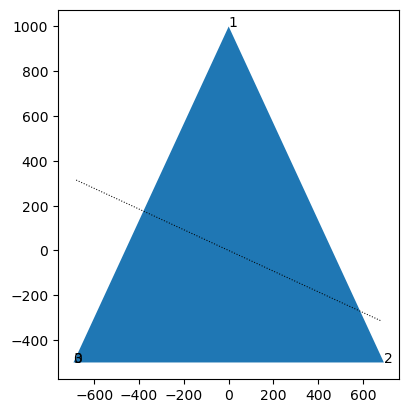

In [1103]:
mirror_lines = symmetries["reflections"]
ax = gpd.GeoSeries([poly]).plot()
if len(mirror_lines) > 0:
  gpd.GeoSeries([affine.rotate(geom.LineString([(-750, 0), (750, 0)]), a) for a in mirror_lines]).plot(ax = ax, color = "k", ls = "dotted", lw = 0.75)
for i, p in enumerate(poly.exterior.coords):
  ax.annotate(text = i, xy = p)

In [1038]:
poly = affine.scale(tiling_utils.get_regular_polygon(1000, n = 5), 1)

pat = get_lengths_and_angles(poly)
X = pat[:-1]
rX = list(reversed(pat[1:]))
S = X + X[:-1]
rS = list(reversed(S))
find_matches(S, X), find_matches(rS, rX)

([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])